In [ ]:
!pip install wget
!python -m wget https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    ./tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=f6f11d66b333b3b732fdcc2d31b9b12ba633635cc76a16e4e58617674c4f2a36
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget

Saved under inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weight_file = "inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

pre_trained_model = InceptionV3(input_shape=(224, 224, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weight_file)

for layer in pre_trained_model.layers:
    layer.trainable = False
    
last_layer = pre_trained_model.get_layer("mixed7")
print("last layer output shape: ", last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/machine_learning/flower_classification/
!pwd

/content/drive/MyDrive/machine_learning/flower_classification
/content/drive/MyDrive/machine_learning/flower_classification


In [ ]:
import numpy as np
import os
import cv2
# path for image data
dataset_folder = "flowers"

# initialize data lists
names = []  # list of names of categories
images = [] # list of cropped images
LIMIT = 100 # maximum number of images to take

for folder in os.listdir(dataset_folder):
    count = 0
    for name in os.listdir(os.path.join(dataset_folder, folder)):
        if name.find(".jpg") > -1:
            img = cv2.imread(os.path.join(dataset_folder + "/" + folder, name))
            img = cv2.resize(img, (224, 224))
            if img is not None:
                names.append(folder)
                images.append(img)
                count += 1
        if count == LIMIT:
            break
        
labels = np.unique(names)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(names)
print(le.classes_)

['astilbe' 'bellflower' 'black_eyed_susan' 'calendula' 'california_poppy'
 'carnation' 'common_daisy' 'coreopsis' 'daffodil' 'dandelion' 'iris'
 'magnolia' 'rose' 'sunflower' 'tulip' 'water_lily']


In [ ]:
names_vector = le.transform(names)
len(names_vector)
len(images)

1600

In [ ]:
# from sklearn.model_selection import train_test_split

# x_train, x_test, y_train, y_test = train_test_split(np.array(images, dtype=np.float32),
#                                                     np.array(names_vector),
#                                                     test_size=.2,
#                                                     random_state=42)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)

train_generator = image_generator.flow_from_directory(batch_size=32,
                                                 directory='flowers',
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                 subset="training",
                                                 class_mode='categorical')

validation_generator = image_generator.flow_from_directory(batch_size=32,
                                                 directory='flowers',
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                 subset="validation",
                                                 class_mode='categorical')

Found 12599 images belonging to 16 classes.
Found 3141 images belonging to 16 classes.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import callbacks

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(.2)(x)
x = layers.Dense(len(le.classes_), activation = 'softmax')(x)

model = Model(pre_trained_model.input, x)

# model.summary()

model.compile(optimizer = Adam(learning_rate=.0001),
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

# history = model.fit_generator(training_datagen.flow(x_train,y_train, batch_size=32),
#                               epochs = 50, validation_data = validation_datagen.flow(x_test, y_test, batch_size=32),
#                               verbose = 1, steps_per_epoch=x_train.shape[0] // 32)

epochs=10
batch_size=32

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = epochs)

Epoch 1/10
393/393 [==============================] - 81s 190ms/step - loss: 0.6583 - accuracy: 0.7944 - val_loss: 0.3985 - val_accuracy: 0.8772
Epoch 2/10
393/393 [==============================] - 73s 186ms/step - loss: 0.0666 - accuracy: 0.9806 - val_loss: 0.4057 - val_accuracy: 0.8782
Epoch 3/10
393/393 [==============================] - 64s 162ms/step - loss: 0.0240 - accuracy: 0.9943 - val_loss: 0.4054 - val_accuracy: 0.8897
Epoch 4/10
393/393 [==============================] - 74s 188ms/step - loss: 0.0163 - accuracy: 0.9963 - val_loss: 0.4053 - val_accuracy: 0.8862
Epoch 5/10
393/393 [==============================] - 73s 186ms/step - loss: 0.0053 - accuracy: 0.9994 - val_loss: 0.3712 - val_accuracy: 0.9018
Epoch 6/10
393/393 [==============================] - 73s 185ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.3529 - val_accuracy: 0.9005
Epoch 7/10
393/393 [==============================] - 72s 184ms/step - loss: 0.0587 - accuracy: 0.9813 - val_loss: 0.6863 - val_ac

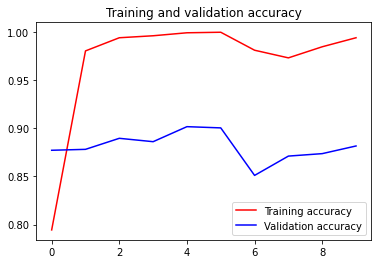

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
model.save("flower_classification.h5")